# Time series with Machine Learning

## Using Machine Learning to Forecast Energy Consumption

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette("hls", 8)
plt.style.use('fivethirtyeight')

### Types of Time Series Data

![](https://miro.medium.com/v2/resize:fit:1400/1*V_RKPeIxCB9CS_2SsLyKXw.jpeg)

In [2]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [3]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


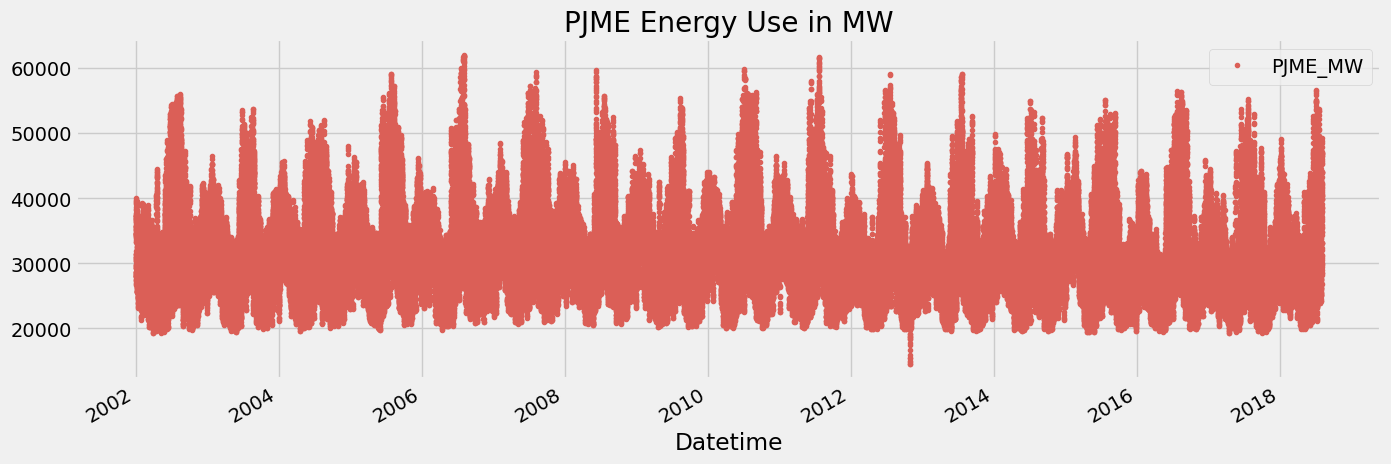

In [4]:
df.plot(style='.',
        figsize=(15,5),
        color=color_pal[0],
        title = 'PJME Energy Use in MW')
plt.show()

### Train/Test split

In [5]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

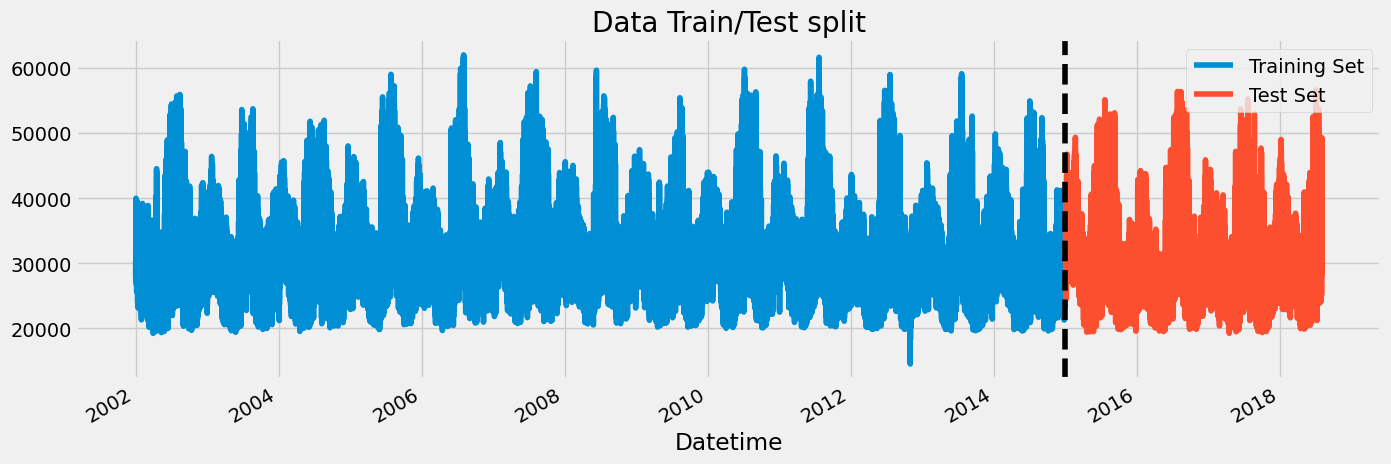

In [6]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

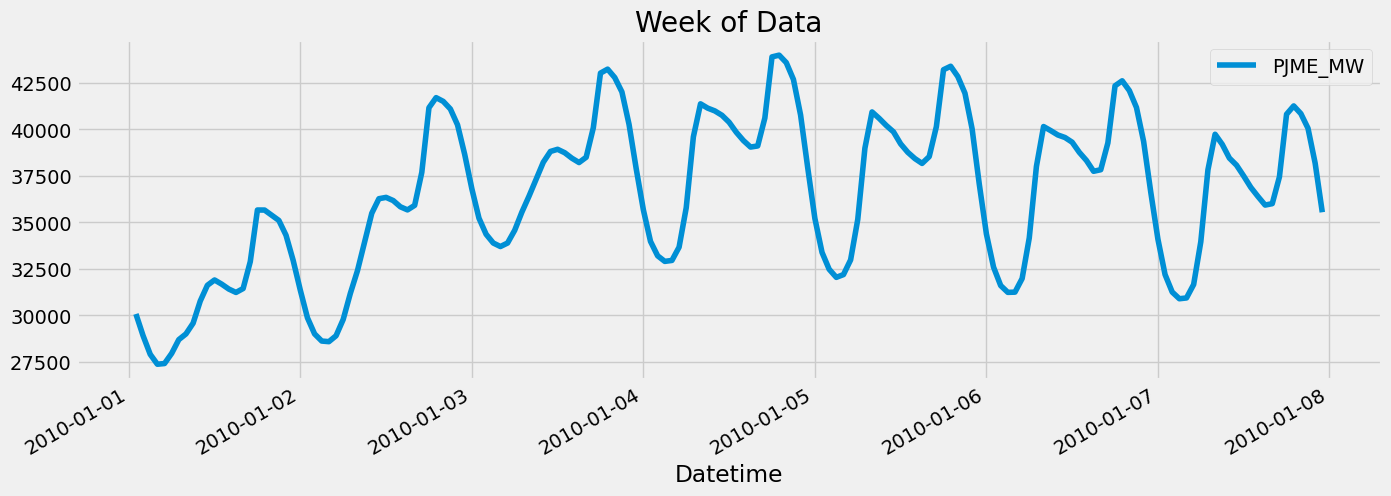

In [7]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15.,5), title='Week of Data')
plt.show()

### Feature Creation

In [8]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

### Visualize our Feature/Target Relationship

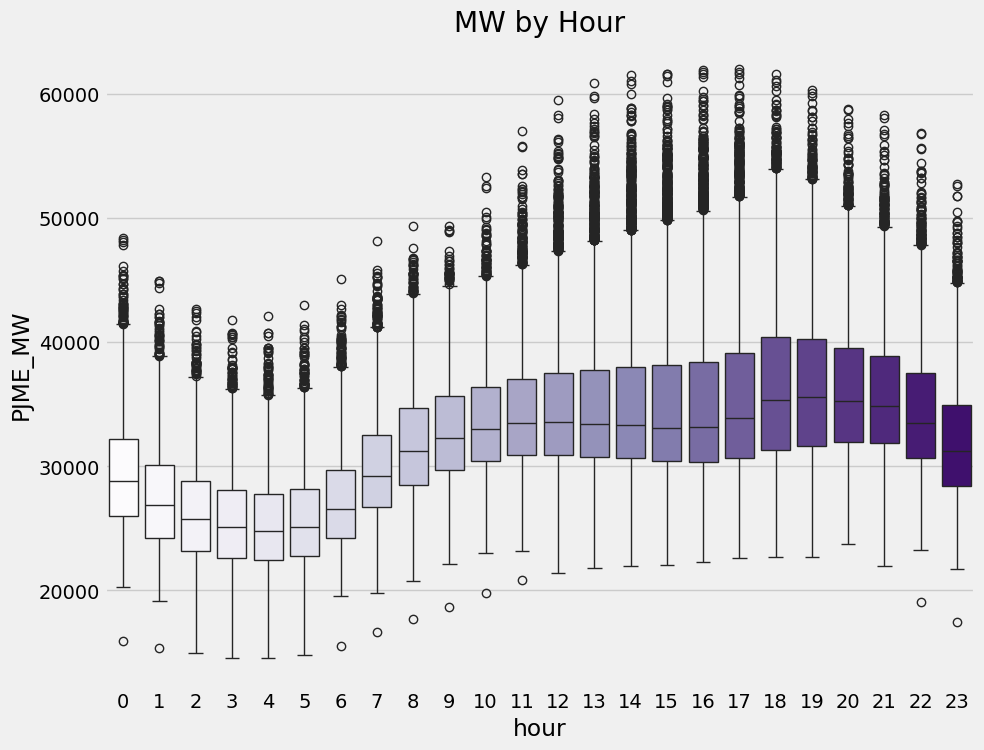

In [9]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW', palette='Purples', hue='hour', legend=False)
ax.set_title('MW by Hour')
plt.show()

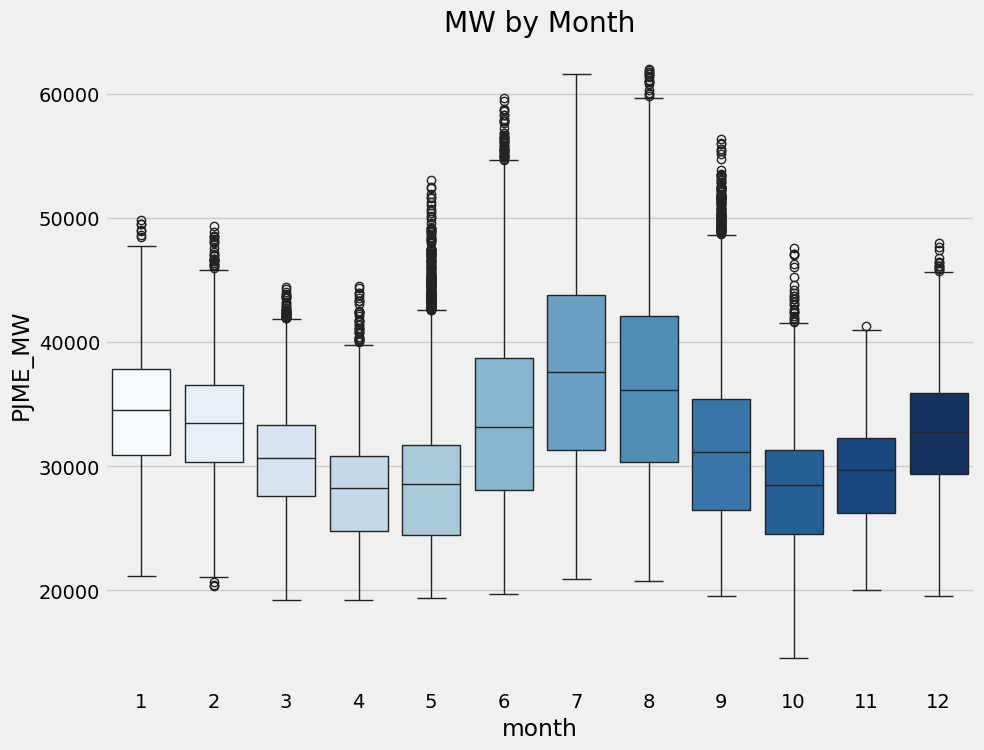

In [10]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues', hue='month', legend=False)
ax.set_title('MW by Month')
plt.show()

### Create our Model

In [11]:
train = create_features(train)
test = create_features(train)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [13]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:32605.13970
[100]	validation_0-rmse:12584.35462	validation_1-rmse:12584.35462
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5837.33066
[300]	validation_0-rmse:3923.28511	validation_1-rmse:3923.28511
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3447.54638
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3288.19208
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3206.55619
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3153.61368
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3114.34038
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3084.39550
[999]	validation_0-rmse:3056.94333	validation_1-rmse:3056.94333


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Feature Importance

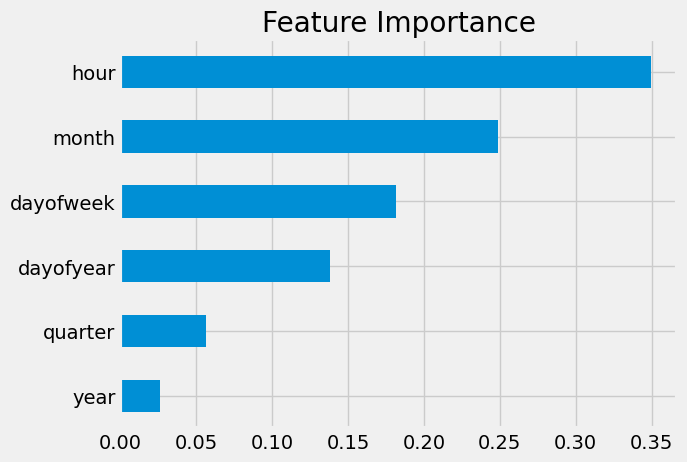

In [26]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance', legend=False)
plt.show()

### Forecast on Test